In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *


In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
reflectance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
reflectance_files_VNIR_april09 = [f[:-4] for f in reflectance_files_VNIR_april09] # remove the .hdr

reflectance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
reflectance_files_SWIR_april09 = [f[:-4] for f in reflectance_files_SWIR_april09] # remove the .hdr

# headwall radiance files... these were built 'by hand' in ENVI
radiance_files_VNIR_april09 = glob('../headwall_data/raw/radiance/VNIR/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob('../headwall_data/raw/radiance/SWIR/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr

# construct the filename pairs with the block numbers
vs_pairs = [(0,0), (7296,7443), (2000,2000), (9040,9054), (16368, 16414)]
hw_vs_pair_names = []
for p in vs_pairs:
    v_block, s_block = p
    v_file = [f for f in radiance_files_VNIR_april09 if f'block{v_block}' in f][0]
    s_file = [f for f in radiance_files_SWIR_april09 if f'block{s_block}' in f][0]
    hw_vs_pair_names.append((v_file, s_file))
    
hw_lbl = [f'HW-{v}-{s}' for v,s in vs_pairs]
hw_lbl

['HW-0-0', 'HW-7296-7443', 'HW-2000-2000', 'HW-9040-9054', 'HW-16368-16414']

In [4]:
reflectance_files_april09, hw_vs_pair_names

(['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5'],
 [('../headwall_data/raw/radiance/VNIR\\headwall_TM1_block0_vnir_rad_glt_cor',
   '../headwall_data/raw/radiance/SWIR\\headwall_TM1_block0_swir_rad_glt_cor'),
  ('../headwall_data/raw/radiance/VNIR\\headwall_TIM_block7296_vnir_rad_glt_cor',
   '../headwall_data/raw/radiance/SWIR\\headwall_TM_block7443_swir_rad_glt_cor'),
  ('../headwall_data/raw/radiance/VNIR\\headwall_TM2_block2000_vnir_rad

In [5]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1

# these are for the reflectance data
data_file_VNIR = reflectance_files_VNIR_april09[hw_ind]
data_file_SWIR = reflectance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

# but replace with the radiance data
data_file_VNIR = '../headwall_data/raw/radiance/VNIR/headwall_TIM_block7296_vnir_rad_glt_cor'
data_file_SWIR = '../headwall_data/raw/radiance/SWIR/headwall_TM_block7443_swir_rad_glt_cor'
data_file_NEON = radiance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

NEON ID:  R10C
../headwall_data/raw/radiance/VNIR/headwall_TIM_block7296_vnir_rad_glt_cor


In [6]:
xarr_VNIR_ls, xarr_SWIR_ls, x_vnir_ls, y_vnir_ls, x_swir_ls, y_swir_ls = [], [], [], [], [], []

for data_file_VNIR, data_file_SWIR in hw_vs_pair_names:
    ## read the data into xarray datasets, chunk with Dask
    # first Headwall
    xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
    xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
    x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
    x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

    # in this case, need to extract out the wavelength information!
    band_vnir = xr.open_rasterio(reflectance_files_VNIR_april09[hw_ind]).coords['band']
    band_swir = xr.open_rasterio(reflectance_files_SWIR_april09[hw_ind]).coords['band']

    xarr_VNIR.coords['band'] = band_vnir
    xarr_SWIR.coords['band'] = band_swir
    
    # append to lists
    xarr_VNIR_ls.append(xarr_VNIR)
    x_vnir_ls.append(x_vnir)
    y_vnir_ls.append(y_vnir)
    
    # append to lists
    xarr_SWIR_ls.append(xarr_SWIR)
    x_swir_ls.append(x_swir)
    y_swir_ls.append(y_swir)

In [7]:
y_vnir_ls[0]

array([40.13078901, 40.13078801, 40.13078701, ..., 40.12955001,
       40.12954901, 40.12954801])

In [8]:
radiance_files_april09
fl_dir = ['NS_N', 'EW_W', 'NS_Both', 'EW', 'NS']
a = {}
for i,fl in enumerate(fl_dir):
    a[fl] = os.path.basename(radiance_files_april09[i])





In [9]:
fl_dir = ['NEON-SN-1', 'NEON-EW', 'NEON-NS', 'NEON-WE', 'NEON-SN-2']

In [10]:
# then NEON (dask chunking done in-function)
x_neon_ls, y_neon_ls, xarr_NEON_ls = [],[],[]
for dfile in radiance_files_april09:
    x_neon, y_neon, xarr_NEON = NEON_create_rad_xarr_from_h5_file(dfile, nid=neon_id)
    
    x_neon_ls.append(x_neon)
    y_neon_ls.append(y_neon)
    xarr_NEON_ls.append(xarr_NEON)



C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been d

# Spatial extraction

In [11]:
buffer_dist = 3 # meters

## use the shapefile
pt_index = 0
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

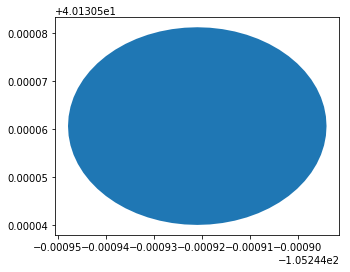

In [12]:
pt_df_hw.plot()

In [13]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)

(41, 54, 270) (41, 54, 270)
(41, 54, 270) (41, 54, 270)
(42, 54, 270) (41, 54, 270)
(41, 54, 270) (41, 54, 270) (41, 54, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:246: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


(41, 54, 270) (42, 53, 270)
(41, 53, 270) (41, 53, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:246: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


(41, 54, 270) (41, 54, 270)


In [14]:
min((41, 54, 270), (42, 53, 270))

(41, 54, 270)

# plot mean of both systems

In [15]:
hw_mean_ls, hw_max_ls, hw_min_ls,  hw_std_ls = [], [], [], []
for full_ex in full_hw_ls:
    hw_mean = np.nanmean(full_ex, axis=1)
    hw_max = np.nanmax(full_ex, axis=1)
    hw_min = np.nanmin(full_ex, axis=1)
    hw_std = np.nanstd(full_ex, axis=1)

    hw_mean_ls.append(hw_mean)
    hw_max_ls.append(hw_max)
    hw_min_ls.append(hw_min)
    hw_std_ls.append(hw_std)

neon_mean_ls, neon_max_ls, neon_min_ls, neon_std_ls = [],[],[],[]
for full_neon in full_neon_ls:
    neon_mean = np.nanmean(full_neon, axis=1)
    neon_max = np.nanmax(full_neon, axis=1)
    neon_min = np.nanmin(full_neon, axis=1)
    neon_std = np.nanstd(full_neon, axis=1)
    
    neon_mean_ls.append(neon_mean)
    neon_max_ls.append(neon_max)
    neon_min_ls.append(neon_min)
    neon_std_ls.append(neon_std)


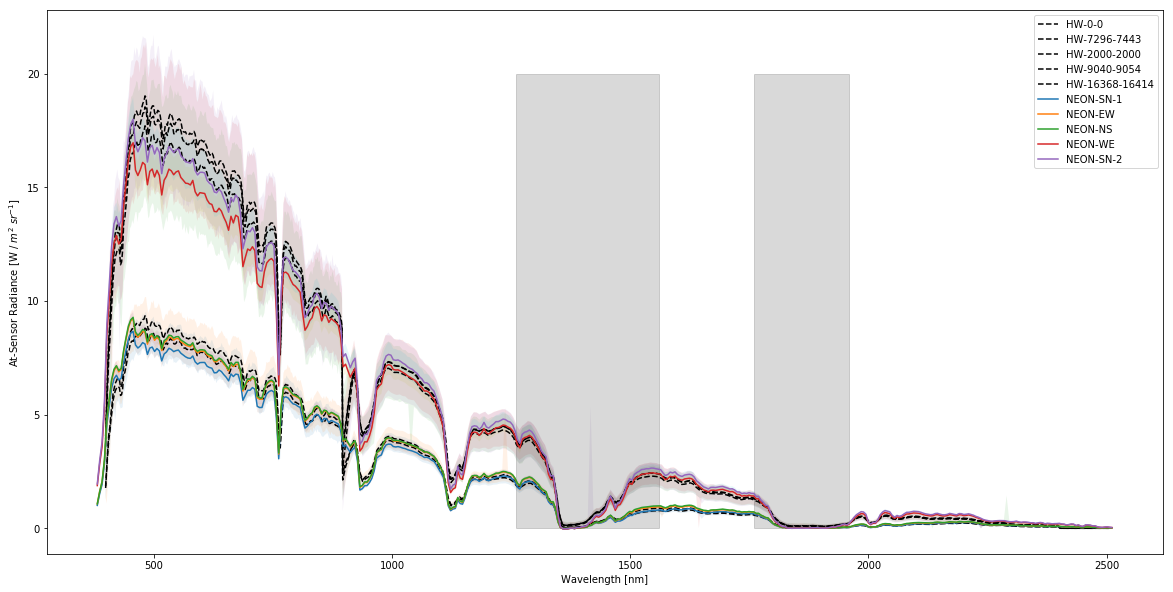

In [16]:
plt.figure(figsize=(20,10))

for full_wav, hw_mean, hw_min, hw_max, hw_l in zip(hw_wav_ls, hw_mean_ls, hw_min_ls, hw_max_ls, hw_lbl):
    plt.plot(full_wav, hw_mean, '--k', label=hw_l)
    plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
    # plt.fill_between(full_wav, full_wav-hw_std, full_wav + hw_std, alpha=0.1)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()         
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

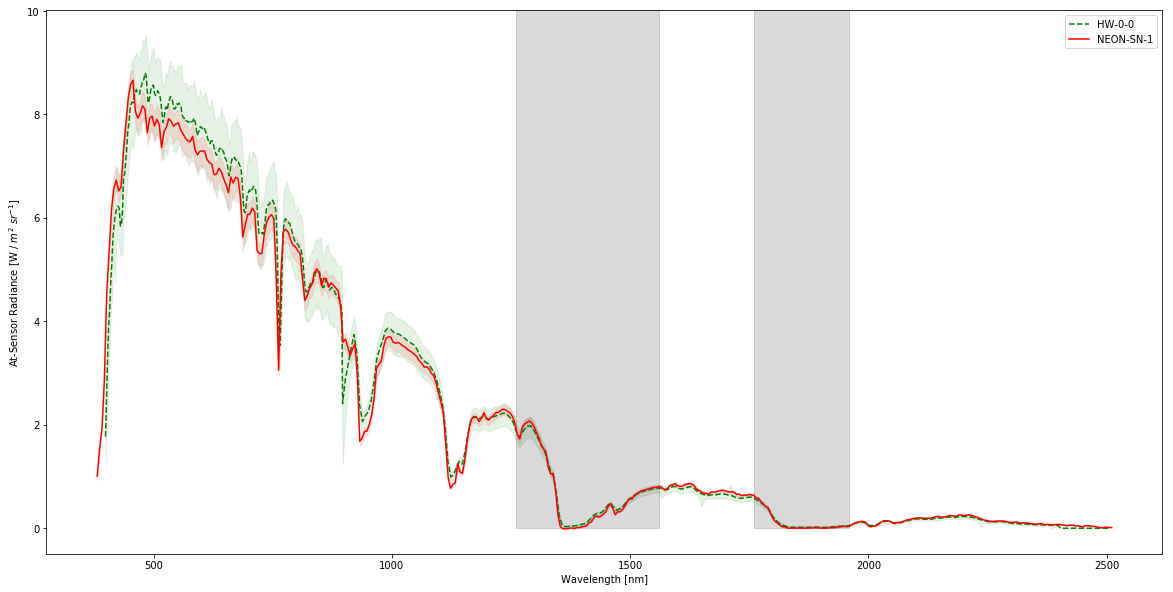

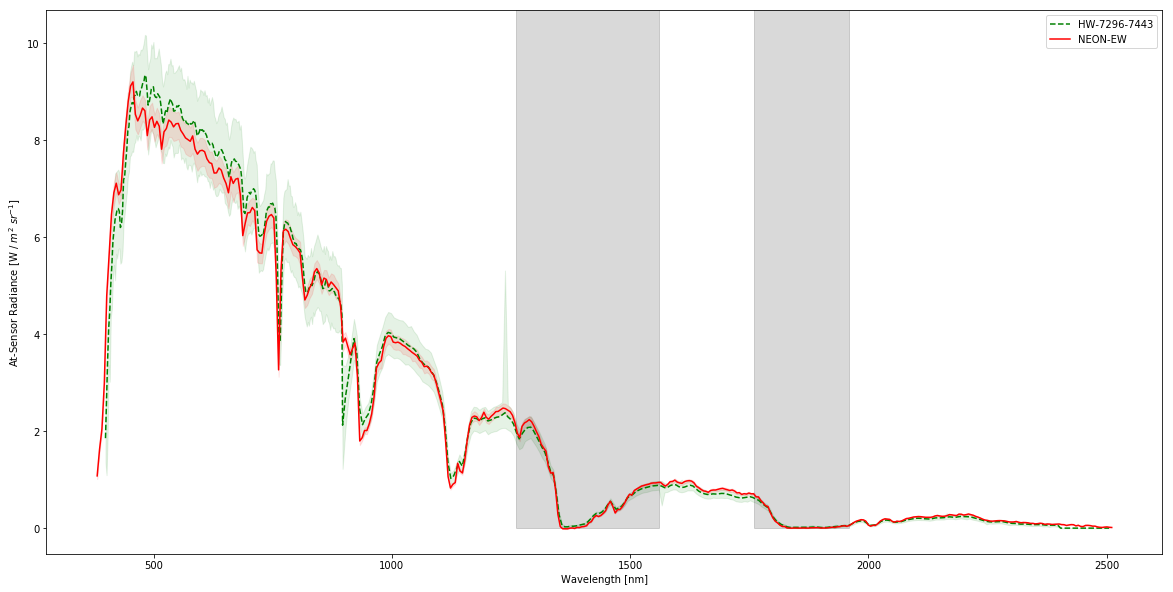

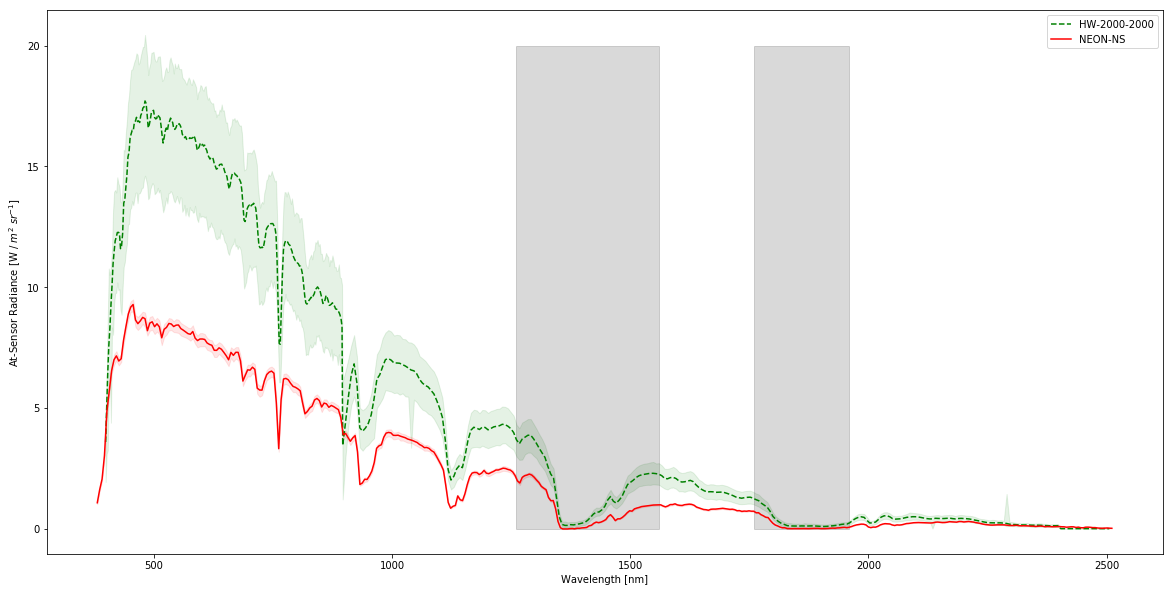

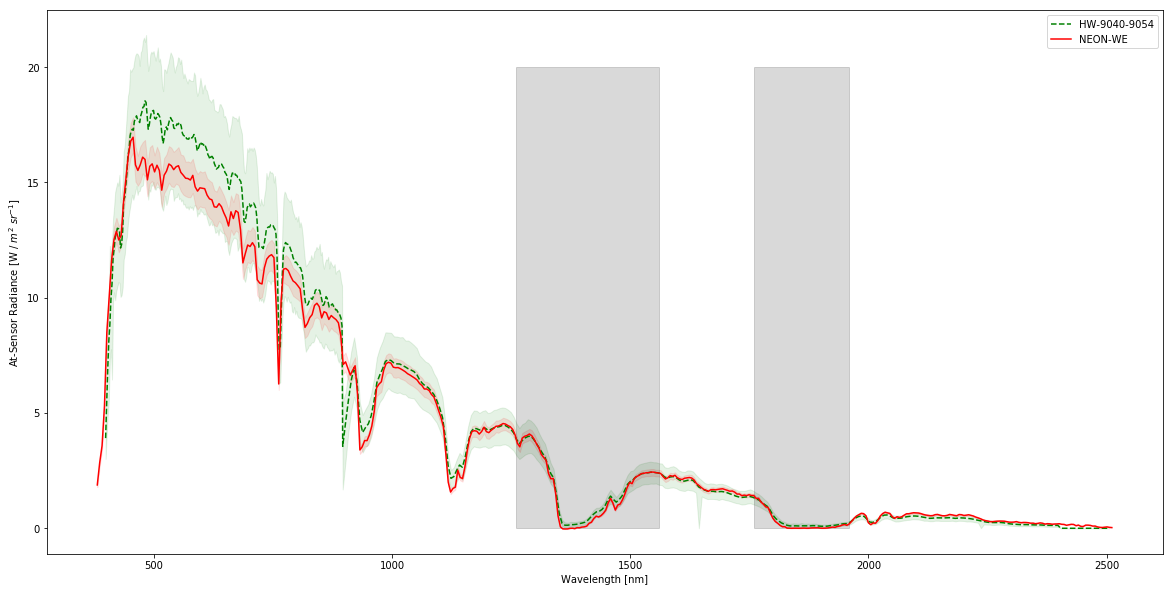

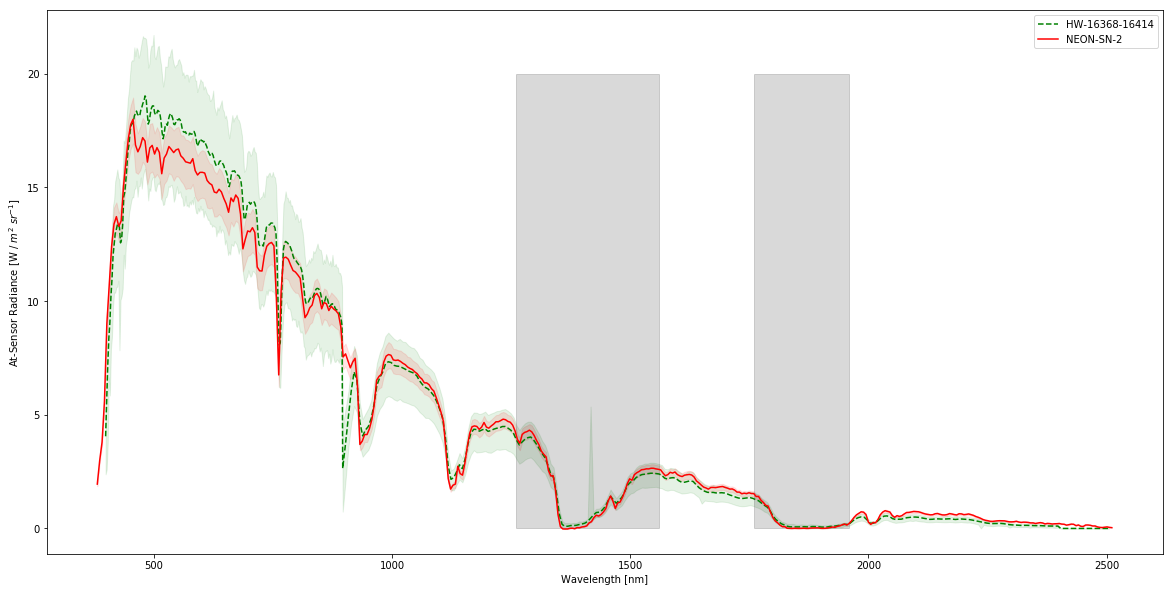

In [17]:
for full_wav, hw_mean, hw_min, hw_max, hw_l, neon_wav, neon_mean, neon_min, neon_max, fl in zip(hw_wav_ls, hw_mean_ls, hw_min_ls, hw_max_ls, hw_lbl,
                                                                                        neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    
    plt.figure(figsize=(20,10))
    
    plt.plot(full_wav, hw_mean, '--g', label=hw_l)
    plt.fill_between(full_wav, hw_min, hw_max, color='g', alpha=0.1)
    # plt.fill_between(full_wav, full_wav-hw_std, full_wav + hw_std, alpha=0.1)


    plt.plot(neon_wav, neon_mean, color='r', label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, color='r', alpha=0.1)

    # 1260 to 1560 nm (Bands 98-128)
    # 1760 to 1960 nm (Bands 148-170)
    plt.gca().add_patch(
        plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

    plt.gca().add_patch(
        plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

    plt.legend()
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
    plt.show()

In [18]:
# ## replot masking bad bands:
# # 1260 to 1560 nm (Bands 98-128)
# # 1760 to 1960 nm (Bands 148-170)
# bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
# bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [19]:
# hw_mean_ma = hw_mean.copy()
# hw_mean_ma[bad_hw] = np.nan
# hw_max_ma = hw_max.copy()
# hw_max_ma[bad_hw] = np.nan
# hw_min_ma = hw_min.copy()
# hw_min_ma[bad_hw] = np.nan

# neon_mean_ma = neon_mean.copy()
# neon_mean_ma[bad_neon] = np.nan
# neon_max_ma = neon_max.copy()
# neon_max_ma[bad_neon] = np.nan
# neon_min_ma = neon_min.copy()
# neon_min_ma[bad_neon] = np.nan


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


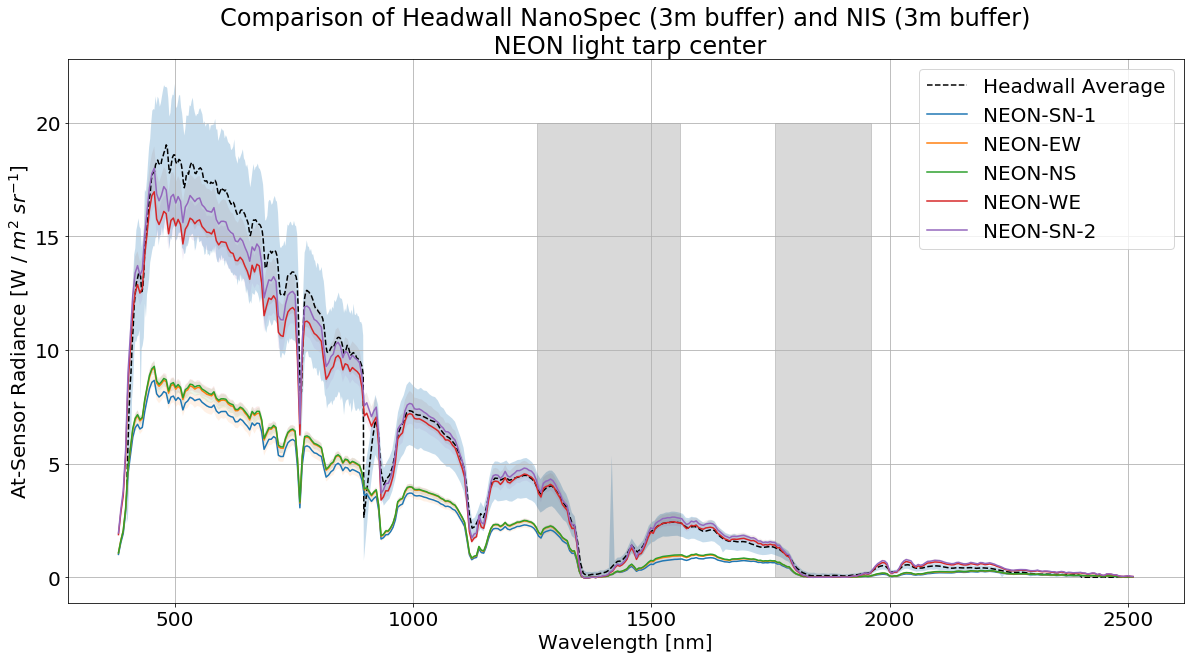

In [20]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
# plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
# plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(full_wav, hw_mean, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.25)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
    
# plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
# plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
bin_res=200
# light_tarp_mean, light_tarp_std = bin_data(full_ex, full_wav, full_neon_ls, neon_wav, bin_res)
light_tarp_mean, light_tarp_std = bin_data_groups(hw_wav_ls, full_wav, full_neon_ls, neon_wav, bin_res)

# Take the average across each sensor

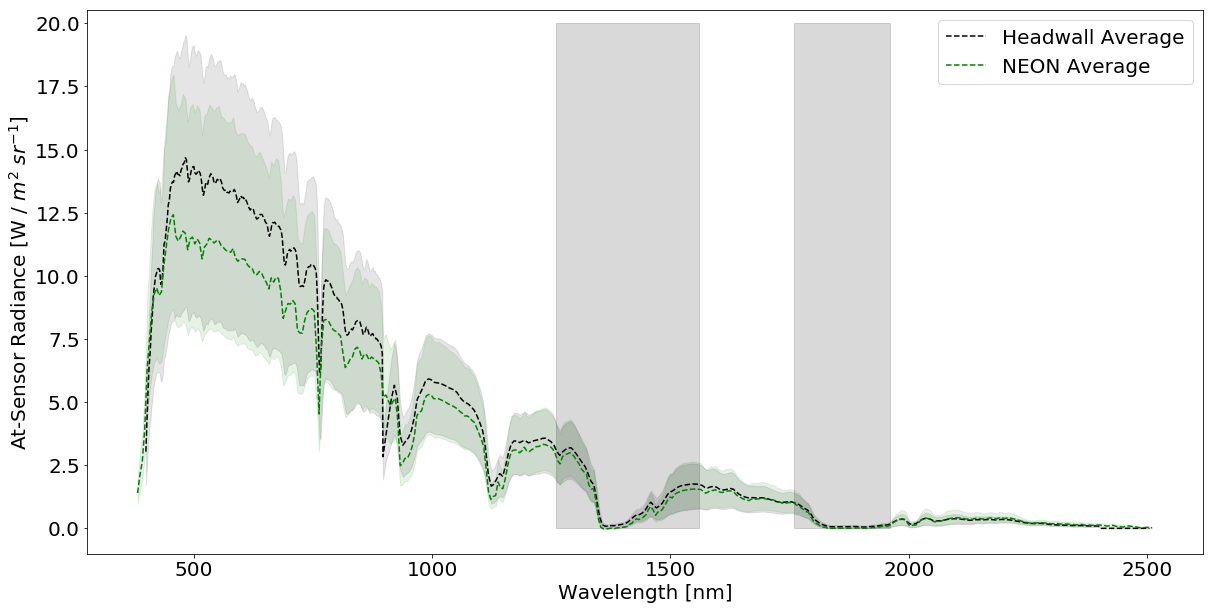

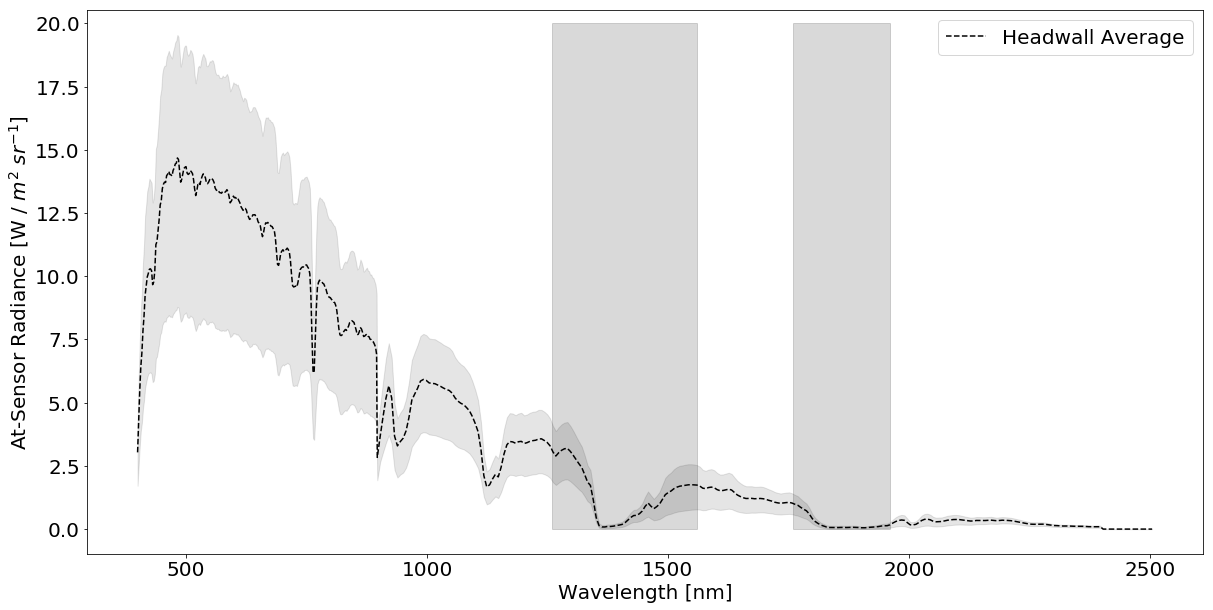

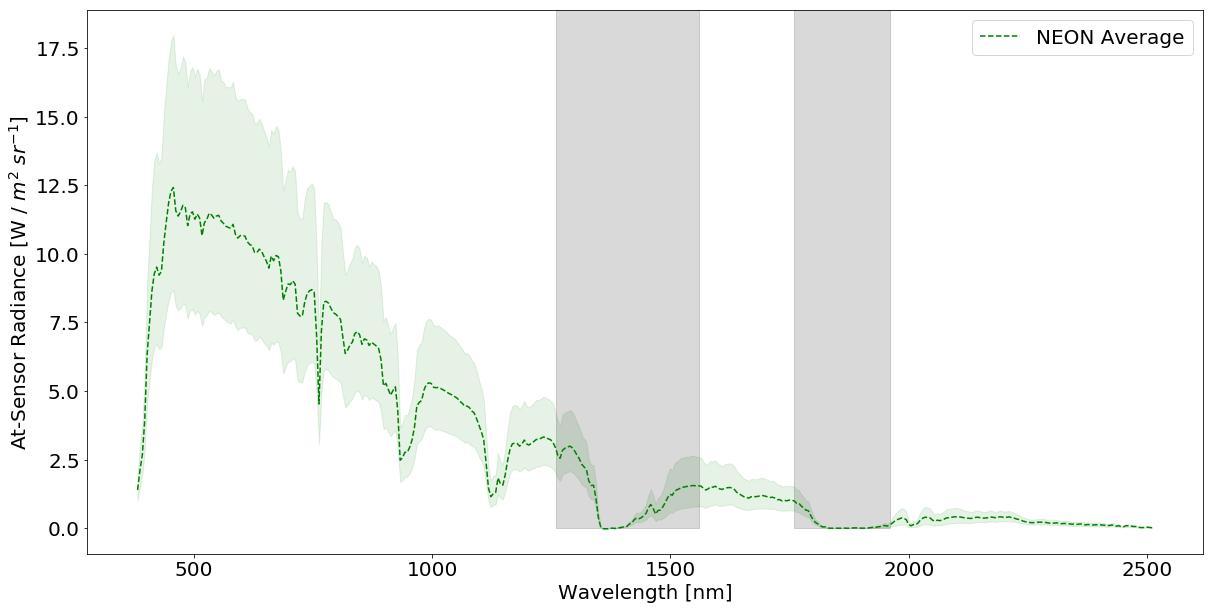

In [22]:
full_hw_avg = np.nanmean(np.hstack(full_hw_ls), axis=1)
full_neon_avg = np.nanmean(np.hstack(full_neon_ls), axis=1)

hw_lower,hw_upper = np.nanquantile(np.hstack(full_hw_ls), 0.1, axis=1, keepdims=True), np.nanquantile(np.hstack(full_hw_ls), 0.9, axis=1, keepdims=True)
neon_lower,neon_upper = np.nanquantile(np.hstack(full_neon_ls), 0.1, axis=1, keepdims=True), np.nanquantile(np.hstack(full_neon_ls), 0.9, axis=1, keepdims=True) 

# eps = np.finfo(np.float32).eps
hw_lower = np.squeeze(hw_lower) 
hw_upper = np.squeeze(hw_upper)
neon_lower = np.squeeze(neon_lower) 
neon_upper = np.squeeze(neon_upper) 

full_hw_avg = np.expand_dims(full_hw_avg, -1)
full_neon_avg = np.expand_dims(full_neon_avg, -1)

hw_std = np.nanstd(np.hstack(full_hw_ls), axis=1, keepdims=True)
neon_std = np.nanstd(np.hstack(full_neon_ls), axis=1, keepdims=True)

    
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, full_hw_avg, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_lower, hw_upper, color='k', alpha=0.1)

plt.plot(neon_wav, full_neon_avg, '--g', label='NEON Average')
plt.fill_between(neon_wav, neon_lower, neon_upper, color='g', alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()    
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(full_wav, full_hw_avg, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_lower, hw_upper, color='k', alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(neon_wav, full_neon_avg, '--g', label='NEON Average')
plt.fill_between(neon_wav, neon_lower, neon_upper, color='g', alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()   
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

# do the same for dark tarp

In [23]:
## use the shapefile
pt_index = 1 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

## do the extraction

In [27]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)
    
    
hw_mean_ls, hw_max_ls, hw_min_ls,  hw_std_ls = [], [], [], []
for full_ex in full_hw_ls:
    hw_mean = np.nanmean(full_ex, axis=1)
    hw_max = np.nanmax(full_ex, axis=1)
    hw_min = np.nanmin(full_ex, axis=1)
    hw_std = np.nanstd(full_ex, axis=1)

    hw_mean_ls.append(hw_mean)
    hw_max_ls.append(hw_max)
    hw_min_ls.append(hw_min)
    hw_std_ls.append(hw_std)

neon_mean_ls, neon_max_ls, neon_min_ls, neon_std_ls = [],[],[],[]
for full_neon in full_neon_ls:
    neon_mean = np.nanmean(full_neon, axis=1)
    neon_max = np.nanmax(full_neon, axis=1)
    neon_min = np.nanmin(full_neon, axis=1)
    neon_std = np.nanstd(full_neon, axis=1)
    
    neon_mean_ls.append(neon_mean)
    neon_max_ls.append(neon_max)
    neon_min_ls.append(neon_min)
    neon_std_ls.append(neon_std)

(40, 52, 270) (41, 53, 270)
(40, 52, 270) (40, 52, 270) (40, 52, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:246: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


(41, 53, 270) (42, 53, 270)
(41, 53, 270) (41, 53, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:246: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


(41, 54, 270) (41, 54, 270)
(40, 53, 270) (41, 53, 270)
(40, 53, 270) (40, 53, 270) (40, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:246: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


(41, 53, 270) (41, 53, 270)


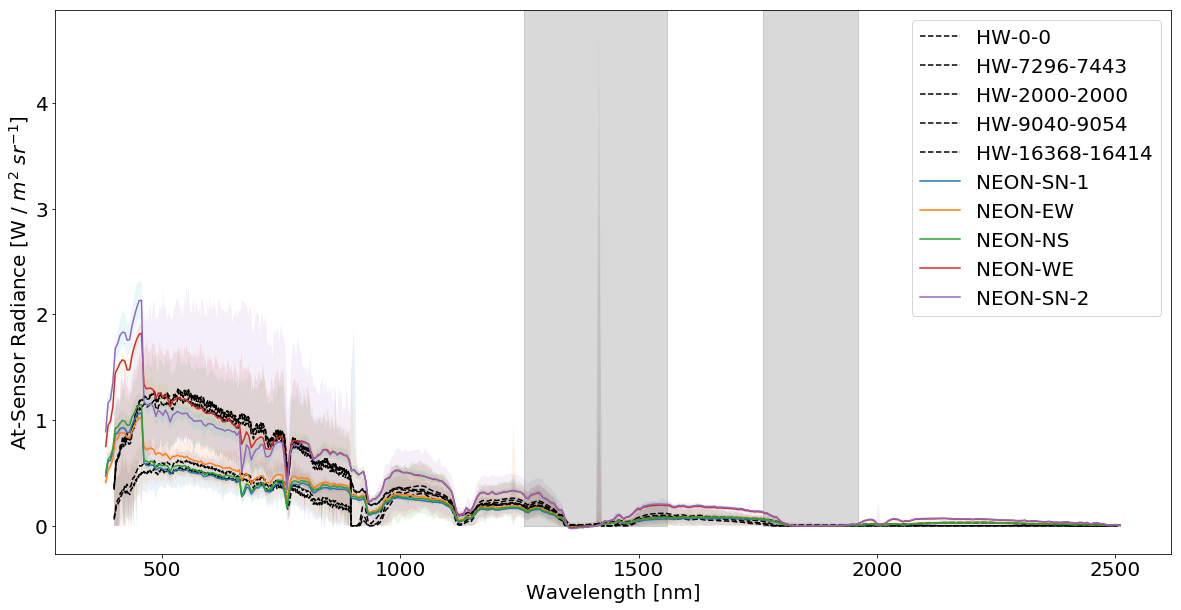

In [28]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))

for full_wav, hw_mean, hw_min, hw_max, hw_l in zip(hw_wav_ls, hw_mean_ls, hw_min_ls, hw_max_ls, hw_lbl):
    plt.plot(full_wav, hw_mean, '--k', label=hw_l)
    plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
    # plt.fill_between(full_wav, full_wav-hw_std, full_wav + hw_std, alpha=0.1)

for neon_wav, neon_mean, neon_min, neon_max, fl in zip(neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    plt.plot(neon_wav, neon_mean, label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()  
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

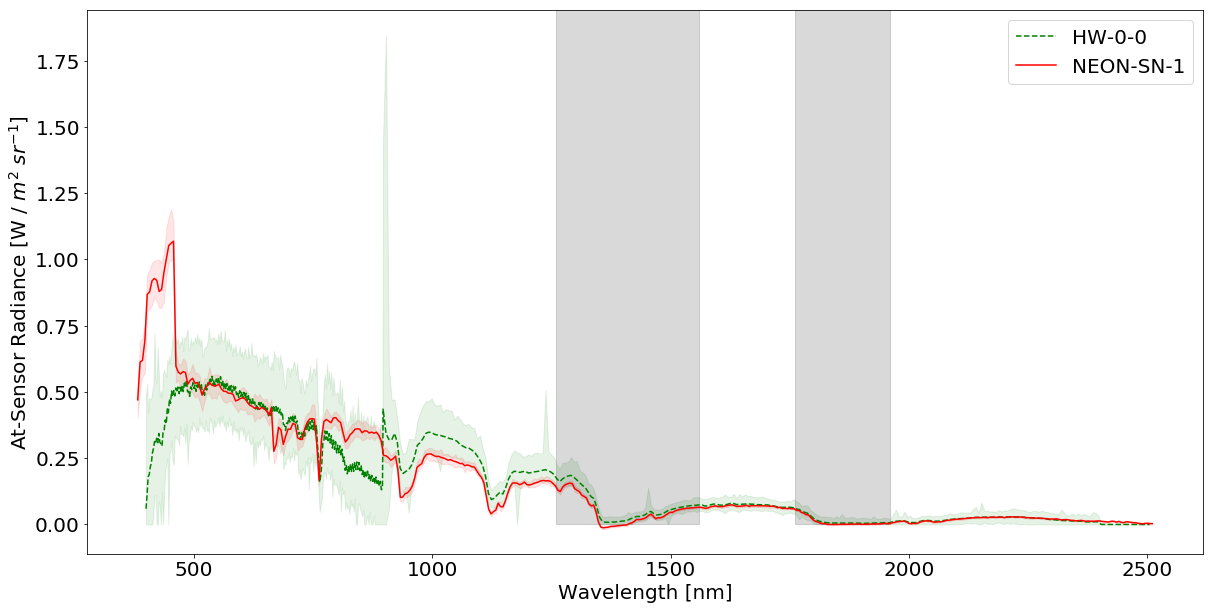

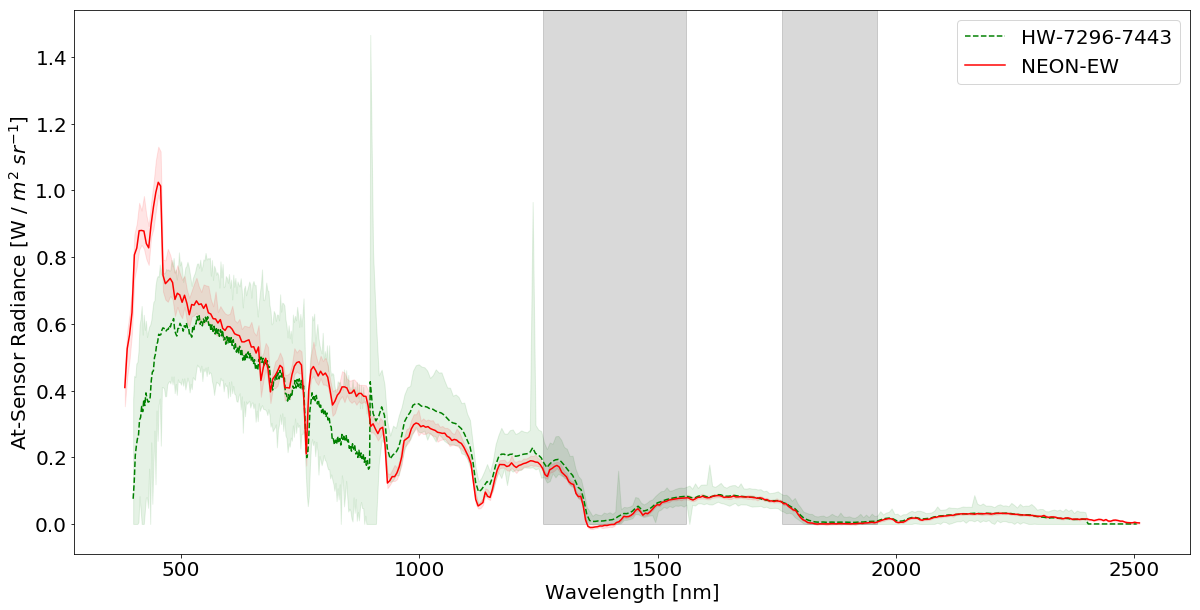

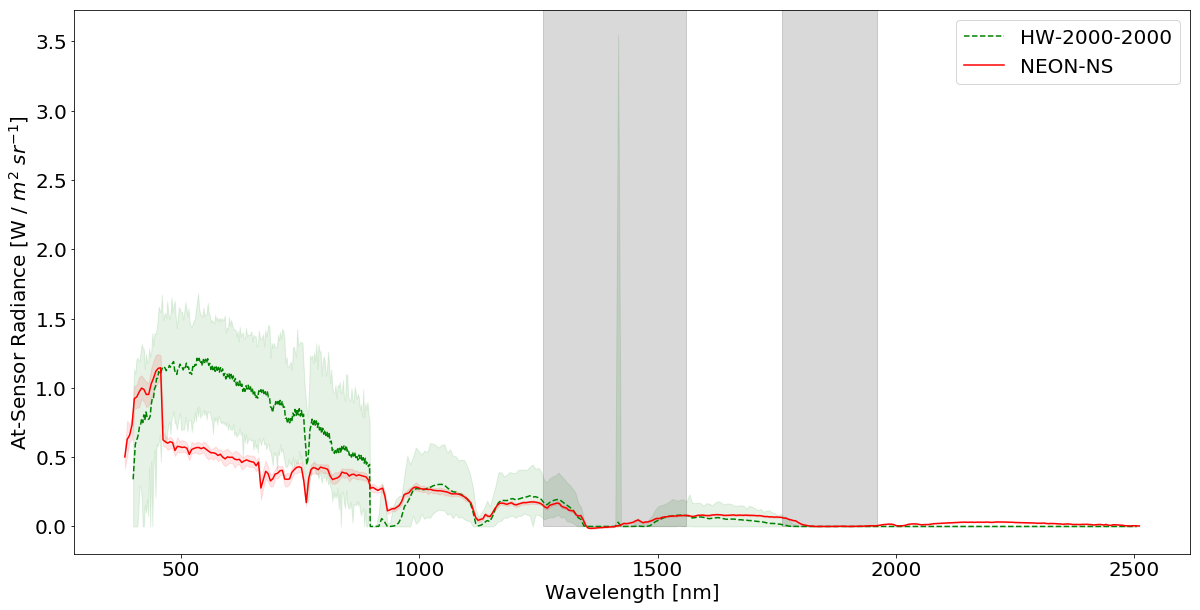

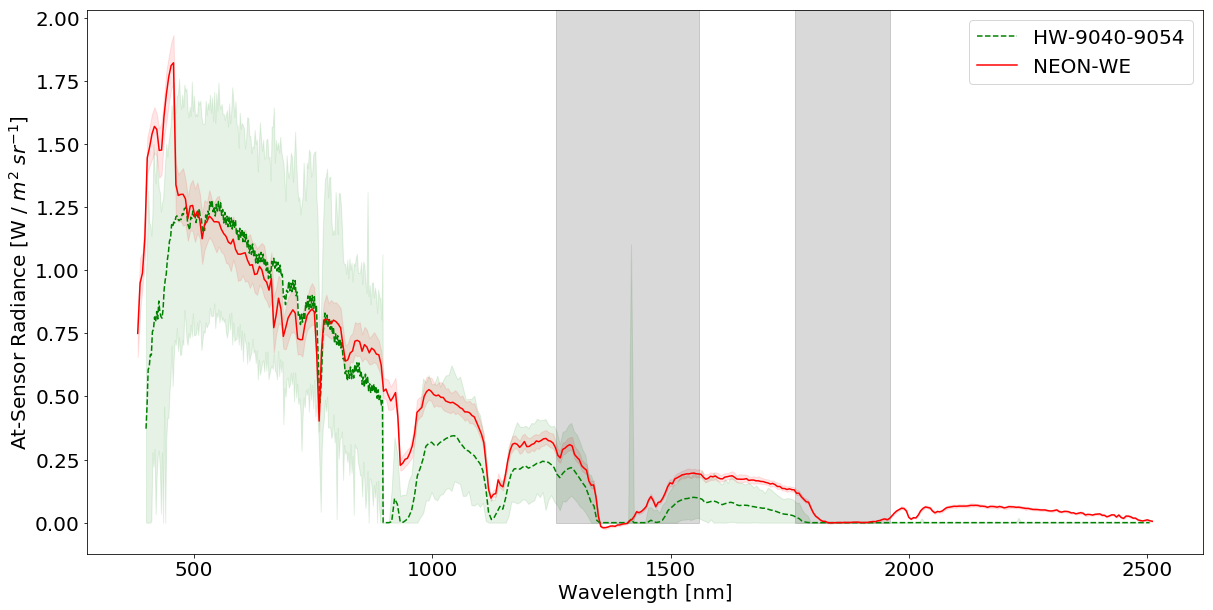

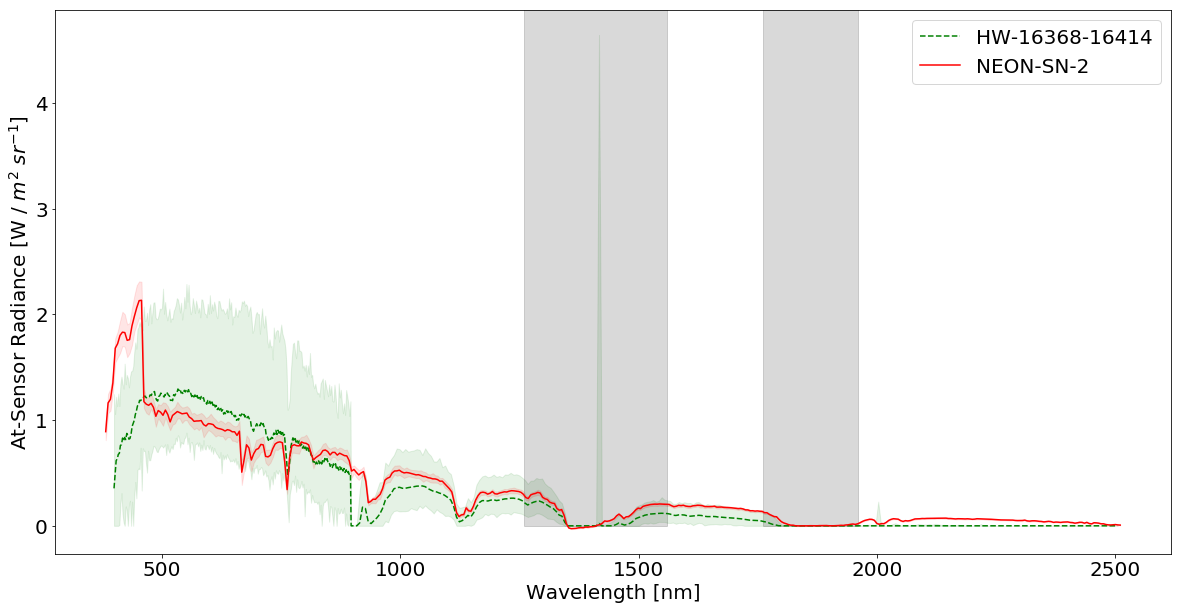

In [29]:
for full_wav, hw_mean, hw_min, hw_max, hw_l, neon_wav, neon_mean, neon_min, neon_max, fl in zip(hw_wav_ls, hw_mean_ls, hw_min_ls, hw_max_ls, hw_lbl,
                                                                                        neon_wav_ls, neon_mean_ls, neon_min_ls, neon_max_ls, fl_dir):
    
    plt.figure(figsize=(20,10))
    
    plt.plot(full_wav, hw_mean, '--g', label=hw_l)
    plt.fill_between(full_wav, hw_min, hw_max, color='g', alpha=0.1)
    # plt.fill_between(full_wav, full_wav-hw_std, full_wav + hw_std, alpha=0.1)


    plt.plot(neon_wav, neon_mean, color='r', label=fl)
    plt.fill_between(neon_wav, neon_min, neon_max, color='r', alpha=0.1)

    # 1260 to 1560 nm (Bands 98-128)
    # 1760 to 1960 nm (Bands 148-170)
    plt.gca().add_patch(
        plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

    plt.gca().add_patch(
        plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

    plt.legend() 
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
    plt.show()

In [30]:
# dark_tarp_mean, dark_tarp_std = bin_data(full_ex, full_wav, full_neon_ls, neon_wav, bin_res)
dark_tarp_mean, dark_tarp_std = bin_data_groups(hw_wav_ls, full_wav, full_neon_ls, neon_wav, bin_res)

# summarize in 200nm bins

In [31]:
#res = 200
res = bin_res
neon_std_ls, hw_std_ls = [],[]
neon_mean_ls, hw_mean_ls = [],[]
band_ranges = []
for bc in np.arange(full_wav[0]+res/2, full_wav[-1], res):
    w_min = bc - res/2
    w_max = bc + res/2
    band_ranges.append((w_min, bc, w_max))
    #print(w_min,bc, w_max)
    
    # get min bands for headwall
    h_b_min = np.where(full_wav >= w_min)[0][0] + 1 # +1 due to 1 based indexing on band
    h_b_max = np.where(full_wav <= w_max)[0][-1] + 1 # +1 due to 1 based indexing on band
    
    # record std and mean for each HW group
    hw_temp_, hw_temp__ = [],[]
    for full_ex in full_hw_ls:

        if len(full_ex.shape) < 2:
            full_ex = full_ex[:, np.newaxis]

        hw_std = np.nanstd(full_ex[h_b_min:h_b_max,:])
        hw_temp_.append(hw_std)

        hw_mean = np.nanmean(full_ex[h_b_min:h_b_max,:])
        hw_temp__.append(hw_mean)

    hw_std_ls.append(hw_temp_)            
    hw_mean_ls.append(hw_temp__)
    
    # get min bands for NEON
    n_b_min = np.where(neon_wav >= w_min)[0][0] + 1 # +1 due to 1 based indexing on band
    n_b_max = np.where(neon_wav <= w_max)[0][-1] + 1 # +1 due to 1 based indexing on band
    
    # record std for each NEON group
    temp_, temp__ = [],[]
    for full_neon in full_neon_ls:
        neon_std = np.nanstd(full_neon[n_b_min:n_b_max,:])
        temp_.append(neon_std)
        
        neon_mean = np.nanmean(full_neon[n_b_min:n_b_max,:])
        temp__.append(neon_mean)
        
    neon_std_ls.append(temp_)
    neon_mean_ls.append(temp__)

    

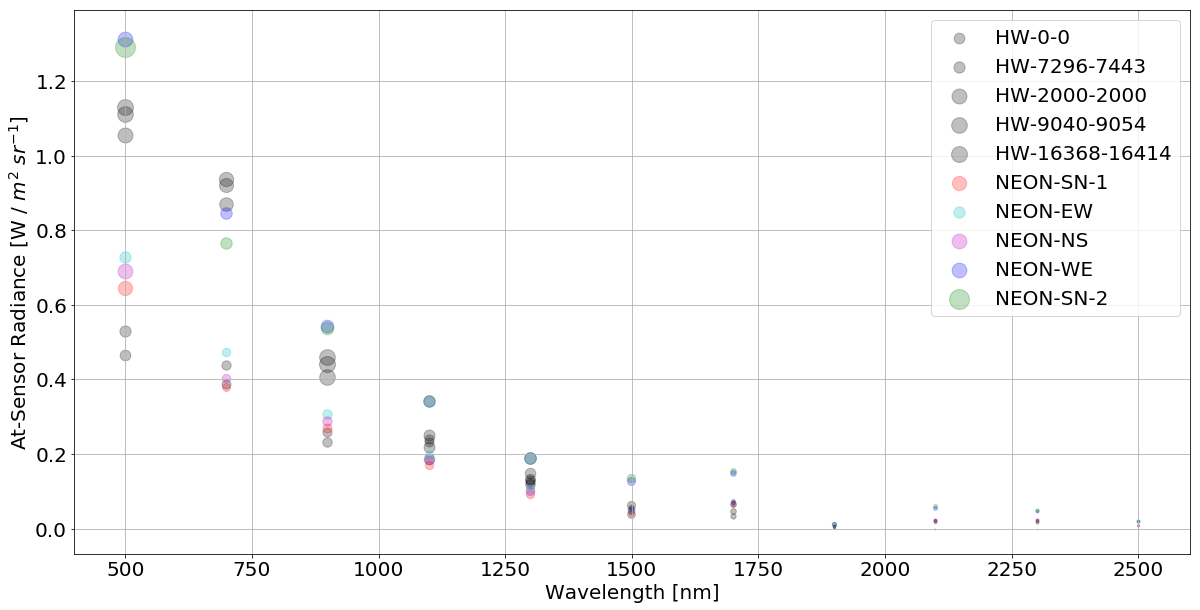

In [33]:
plt.figure(figsize=(20,10))
colors=['k','r', 'c', 'm', 'b', 'g']
for i in range(len(hw_std_ls)):
    
    for k in range(len(hw_mean_ls[i])):
        plt.scatter(band_ranges[i][1], hw_mean_ls[i][k], color=colors[0], s=hw_std_ls[i][k]*1000, alpha=0.25, label=hw_lbl[k])
    
    for j in range(len(neon_mean_ls[i])):
        #print(neon_mean_ls[i][j])
        plt.scatter(band_ranges[i][1], neon_mean_ls[i][j], color=colors[j+1], s=neon_std_ls[i][j]*1000, alpha=0.25, label=fl_dir[j])

    if i==0:
        plt.legend()
        
plt.grid(True)        
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

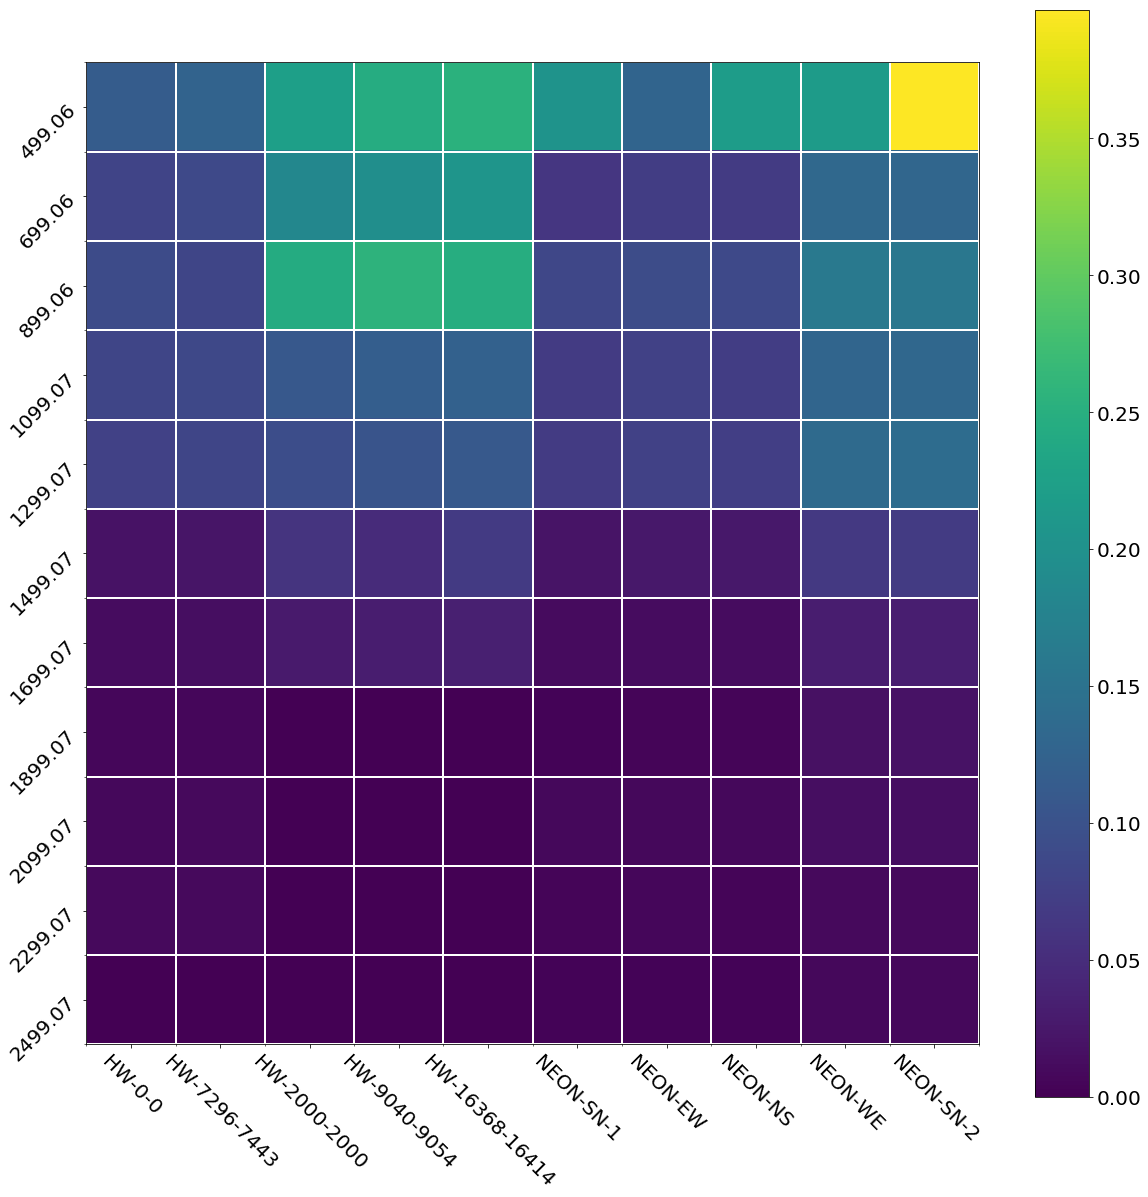

In [34]:
arr_std = np.hstack((np.array(hw_std_ls), np.array(neon_std_ls)))

fig, ax1 = plt.subplots(figsize=(20,20))
a = ax1.imshow(arr_std, alpha=1.0)
ax1.set_xticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_yticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_xticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_yticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_yticklabels([round(b[1],2) for b in band_ranges], rotation=45)
ax1.set_xticklabels(hw_lbl + fl_dir, rotation=-45)
plt.colorbar(a)
plt.show()


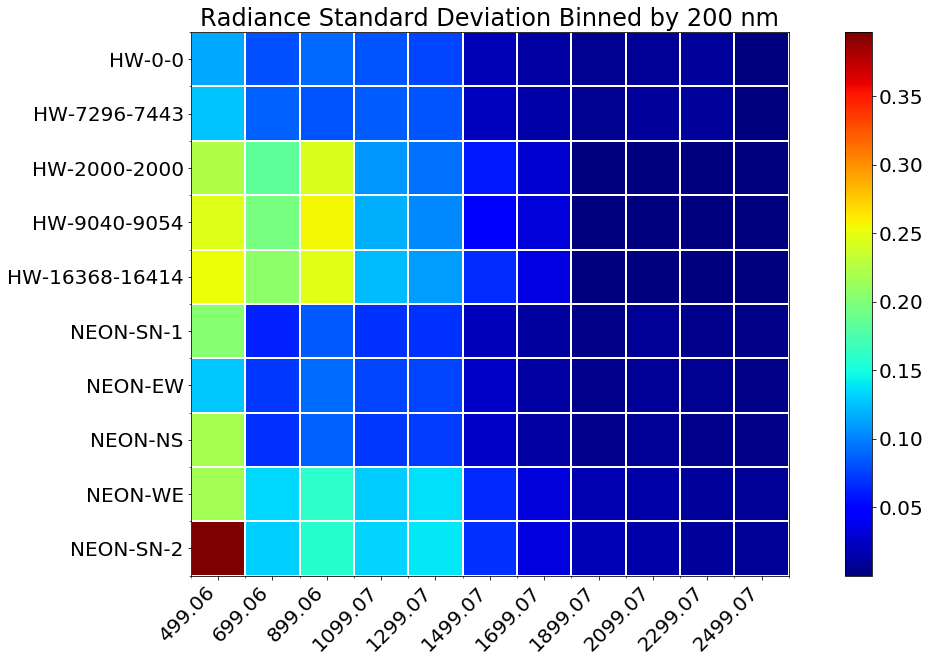

In [45]:
fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(arr_std.T, alpha=1.0, cmap='jet')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(hw_lbl + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance Standard Deviation Binned by {} nm'.format(res))
plt.show()

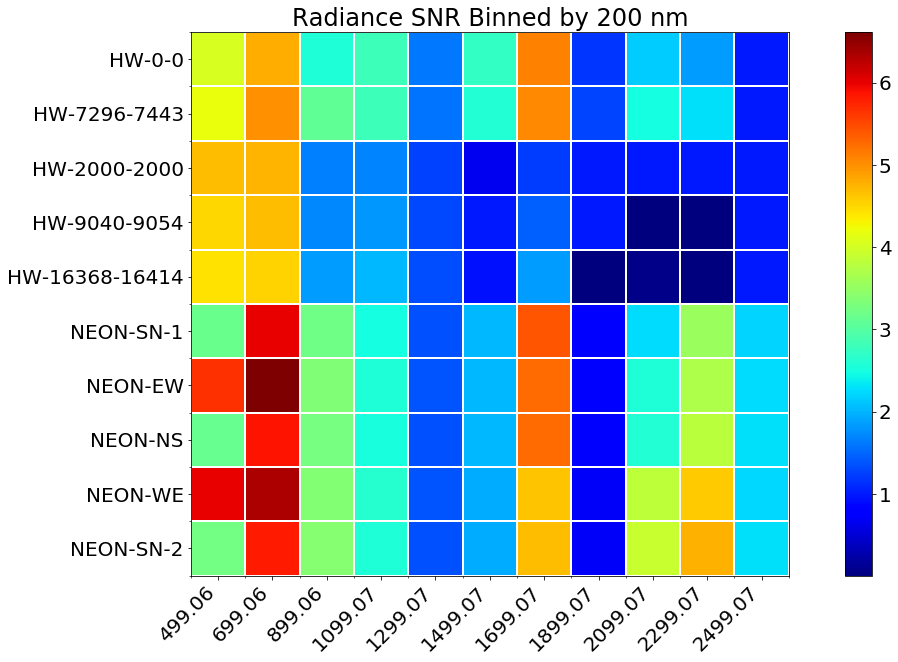

In [46]:
arr_std = np.hstack((np.array(hw_std_ls), np.array(neon_std_ls))) + np.finfo(np.float32).eps
arr_mean = np.hstack((np.array(hw_mean_ls), np.array(neon_mean_ls))) + np.finfo(np.float32).eps
arr_snr = arr_mean / arr_std

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(arr_snr.T, alpha=1.0, cmap='jet')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(hw_lbl + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR Binned by {} nm'.format(res))
plt.show()

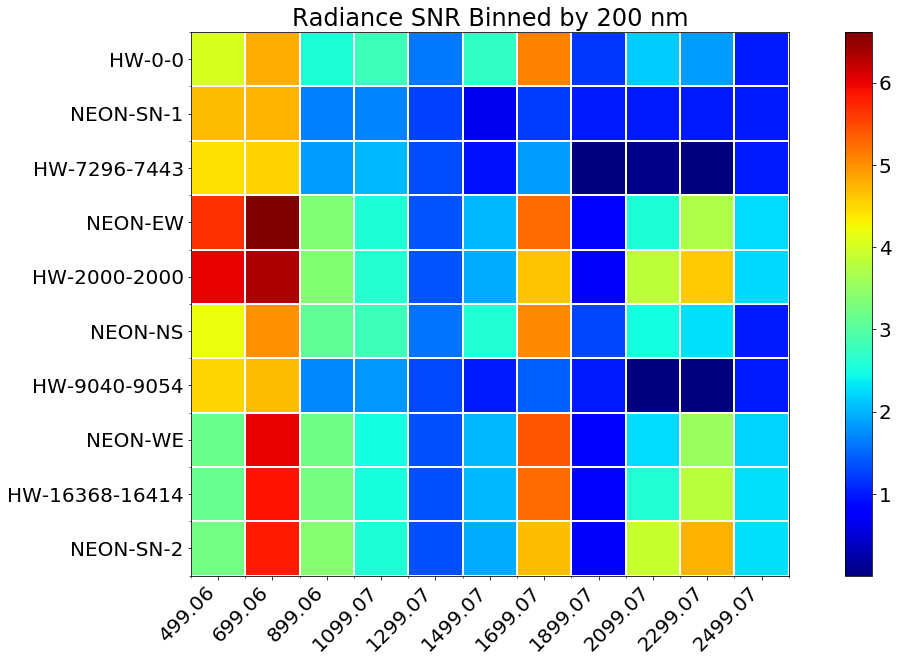

In [47]:
new_rows = [0,5,1,6,2,7,3,8,4,9]
i = np.argsort(new_rows)
new_snr = arr_snr[:,i]

all_labels = hw_lbl+fl_dir
new_labels = [all_labels[new_rows[i]] for i,l in enumerate(all_labels)]

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(new_snr.T, alpha=1.0, cmap='jet')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(new_labels, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR Binned by {} nm'.format(res))
plt.show()

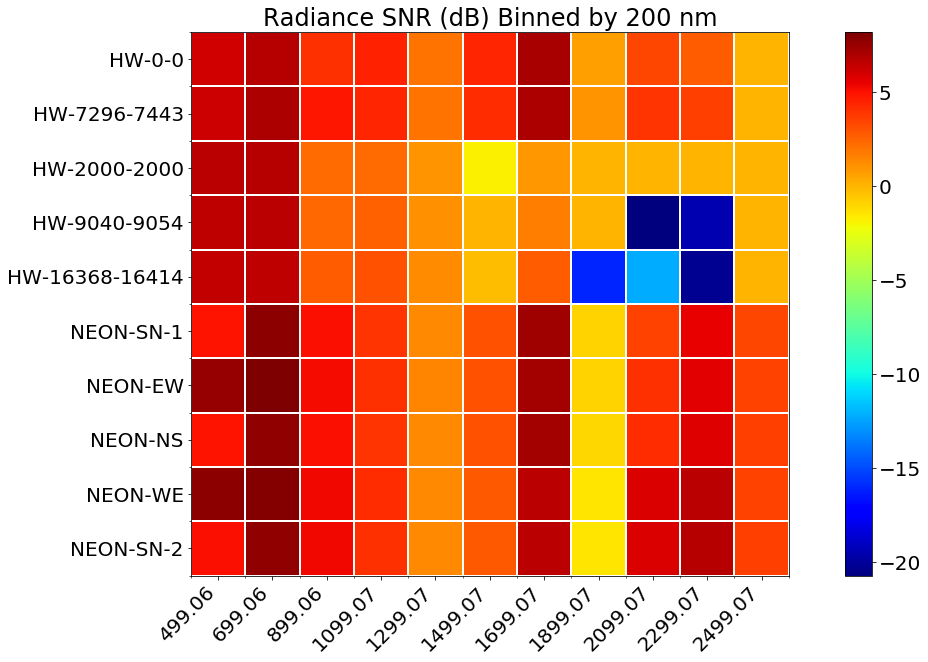

In [48]:
arr_std = np.hstack((np.array(hw_std_ls), np.array(neon_std_ls))) + np.finfo(np.float32).eps
arr_mean = np.hstack((np.array(hw_mean_ls), np.array(neon_mean_ls))) + np.finfo(np.float32).eps
arr_snr = 10*np.log10(arr_mean / arr_std) #dB

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(arr_snr.T, alpha=1.0, cmap='jet')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(hw_lbl + fl_dir, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR (dB) Binned by {} nm'.format(res))
plt.show()

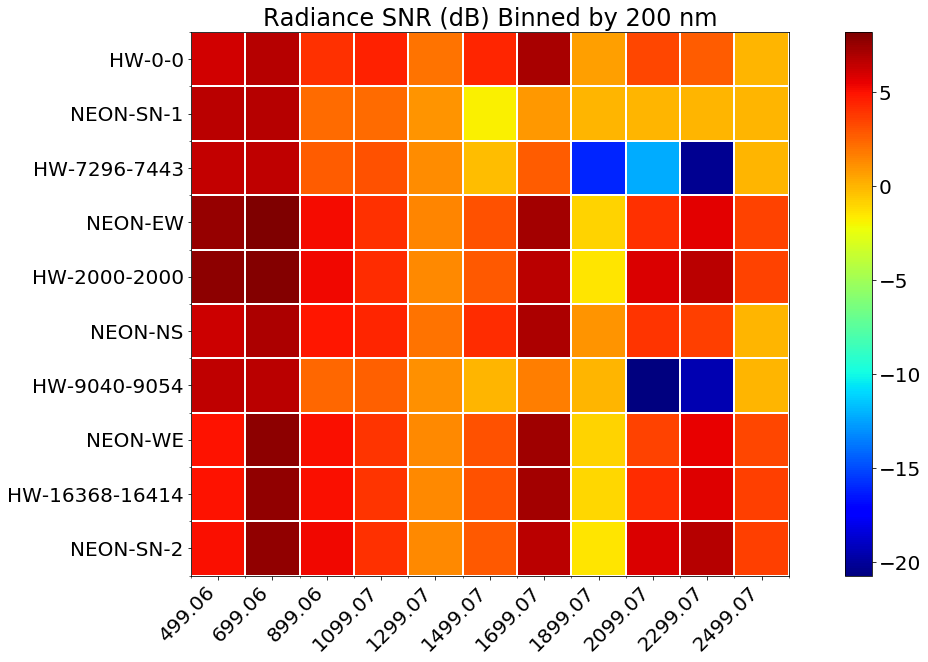

In [54]:
arr_snr = 10*np.log10(arr_mean / arr_std) #dB

new_rows = [0,5,1,6,2,7,3,8,4,9]
i = np.argsort(new_rows)
new_snr = arr_snr[:,i]

all_labels = hw_lbl+fl_dir
new_labels = [all_labels[new_rows[i]] for i,l in enumerate(all_labels)]

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(new_snr.T, alpha=1.0, cmap='jet')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(new_labels, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR (dB) Binned by {} nm'.format(res))
plt.show()

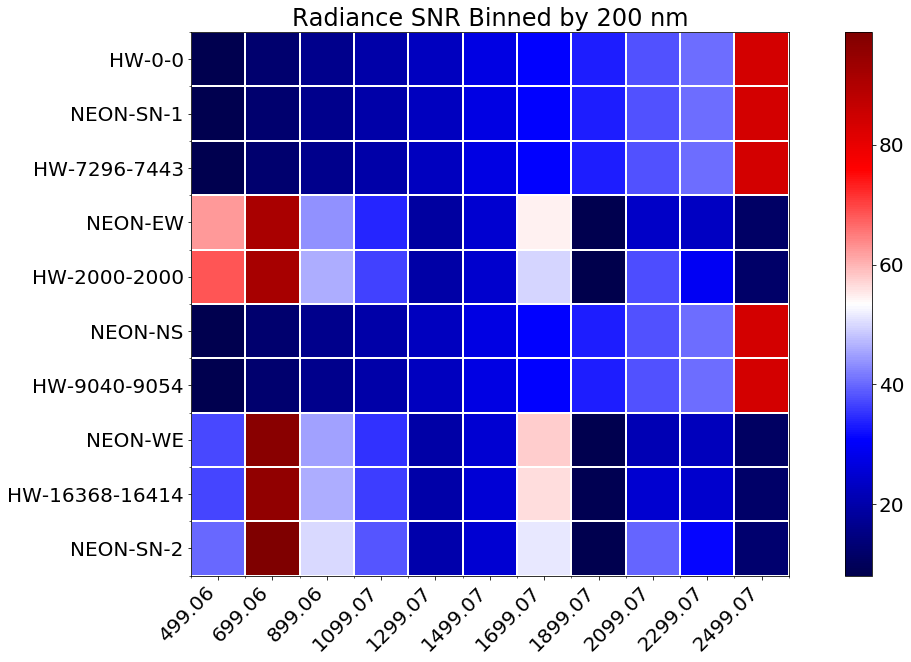

In [55]:
arr_snr = light_tarp_mean / dark_tarp_std

new_rows = [0,5,1,6,2,7,3,8,4,9]
i = np.argsort(new_rows)
new_snr = arr_snr[:,i]

all_labels = hw_lbl+fl_dir
new_labels = [all_labels[new_rows[i]] for i,l in enumerate(all_labels)]

fig, ax1 = plt.subplots(figsize=(20,10))
a = ax1.imshow(new_snr.T, alpha=1.0, cmap='seismic')
ax1.set_yticks(np.arange(0, arr_std.shape[1], 1));
ax1.set_xticks(np.arange(0, arr_std.shape[0], 1));

# Minor ticks
ax1.set_yticks(np.arange(-.5, arr_std.shape[1], 1), minor=True);
ax1.set_xticks(np.arange(-.5, arr_std.shape[0], 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1.set_xticklabels([round(b[1],2) for b in band_ranges], rotation=45, ha='right')
ax1.set_yticklabels(new_labels, rotation=0)
plt.colorbar(a)
plt.title('Radiance SNR Binned by {} nm'.format(res))
plt.show()

# Take average across all flightlines for each sensor

In [41]:
full_hw_avg = np.nanmean(np.hstack(full_hw_ls), axis=1)
full_neon_avg = np.nanmean(np.hstack(full_neon_ls), axis=1)

hw_lower,hw_upper = np.nanquantile(np.hstack(full_hw_ls), 0.1, axis=1, keepdims=True), np.nanquantile(np.hstack(full_hw_ls), 0.9, axis=1, keepdims=True)
neon_lower,neon_upper = np.nanquantile(np.hstack(full_neon_ls), 0.1, axis=1, keepdims=True), np.nanquantile(np.hstack(full_neon_ls), 0.9, axis=1, keepdims=True) 

# eps = np.finfo(np.float32).eps
hw_lower = np.squeeze(hw_lower) 
hw_upper = np.squeeze(hw_upper)
neon_lower = np.squeeze(neon_lower) 
neon_upper = np.squeeze(neon_upper) 

full_hw_avg = np.expand_dims(full_hw_avg, -1)
full_neon_avg = np.expand_dims(full_neon_avg, -1)

hw_std = np.nanstd(np.hstack(full_hw_ls), axis=1, keepdims=True)
neon_std = np.nanstd(np.hstack(full_neon_ls), axis=1, keepdims=True)

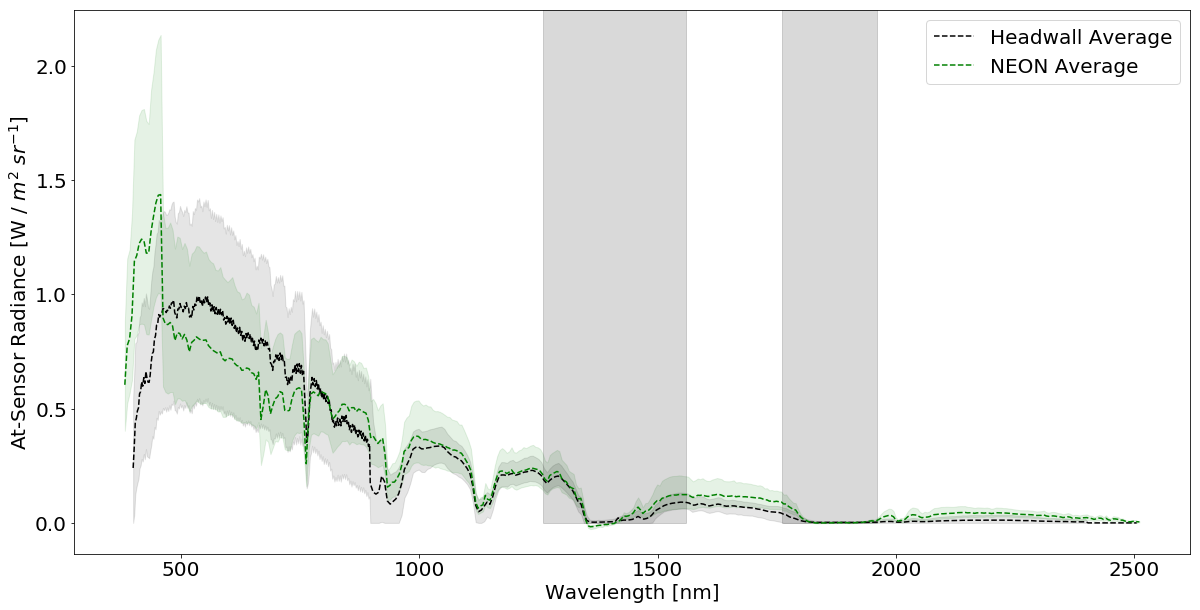

In [42]:
    
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, full_hw_avg, '--k', label='Headwall Average')
plt.fill_between(full_wav, hw_lower, hw_upper, color='k', alpha=0.1)

plt.plot(neon_wav, full_neon_avg, '--g', label='NEON Average')
plt.fill_between(neon_wav, neon_lower, neon_upper, color='g', alpha=0.1)

# plt.plot(full_wav, full_hw_avg, 'k', label='Headwall Average')
# plt.plot(full_wav, hw_lower, '--k', alpha=0.5)
# plt.plot(full_wav, hw_upper, '--k', alpha=0.5)

# plt.plot(neon_wav, full_neon_avg, 'g', label='NEON Average')
# plt.plot(neon_wav, neon_lower, '--g', alpha=0.5)
# plt.plot(neon_wav, neon_upper, '--g', alpha=0.5)


# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()    
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

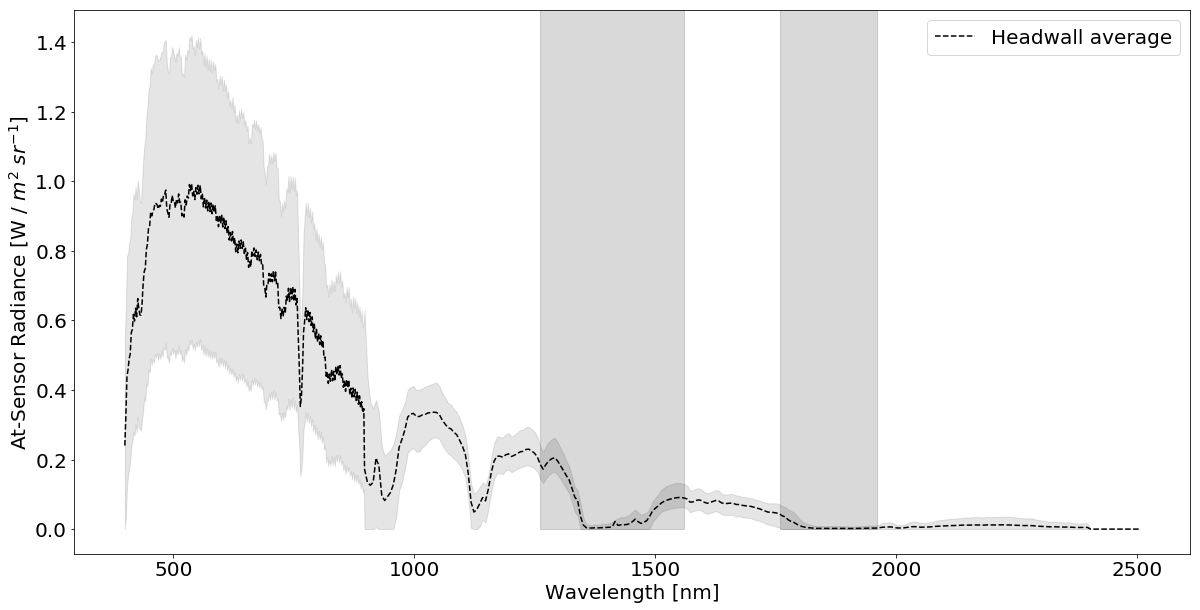

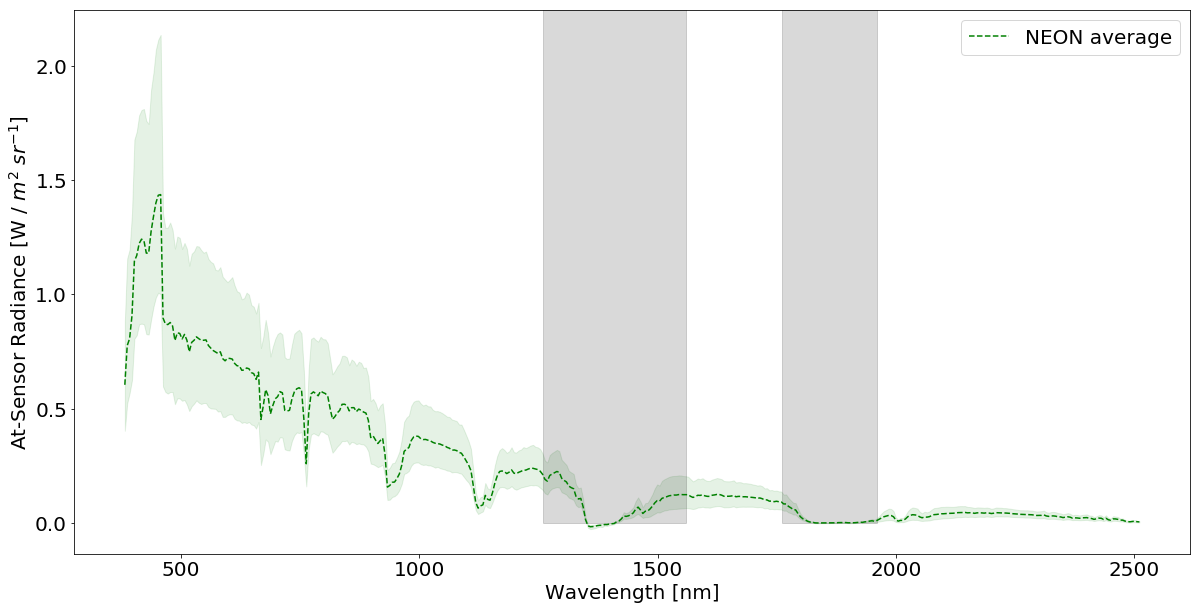

In [43]:
    
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
# plt.plot(full_wav, full_hw_avg, '--k', label='Headwall Average')
# plt.fill_between(full_wav, hw_lower, hw_upper, 'k', alpha=0.1)


plt.fill_between(full_wav, hw_lower, hw_upper, alpha=0.1, color='k')
plt.plot(full_wav, full_hw_avg, '--k', label='Headwall average')


# plt.plot(full_wav, full_hw_avg, 'k', label='Headwall Average')
# plt.plot(full_wav, hw_lower, '--k', alpha=0.5)
# plt.plot(full_wav, hw_upper, '--k', alpha=0.5)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()

plt.figure(figsize=(20,10))

plt.fill_between(neon_wav, neon_lower, neon_upper, alpha=0.1, color='g')
plt.plot(neon_wav, full_neon_avg, '--g', label='NEON average')

# plt.plot(neon_wav, full_neon_avg, 'g', label='NEON Average')
# plt.plot(neon_wav, neon_lower, '--g', alpha=0.5)
# plt.plot(neon_wav, neon_upper, '--g', alpha=0.5)

# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
plt.gca().add_patch(
    plt.Rectangle((1260,0), 1560-1260, 20,color='k', alpha=0.15))

plt.gca().add_patch(
    plt.Rectangle((1760,0), 1960-1760, 20,color='k', alpha=0.15))

plt.legend()   
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.show()